# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 3 & 4
# Preliminaries operations

## Import needed libraries

In [2]:
#Import needed libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



## 0.1 Data preparation & standardization

In [3]:
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"], axis=1, inplace=True)
ddos_data_original = ddos_data.copy()
ddos_data = ddos_data.set_index('Flow ID')
print(ddos_data)
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state=15)
X_s = pca.fit_transform(X_s)


                                        Source Port  Destination Port  \
Flow ID                                                                 
172.16.0.5-192.168.50.1-634-60495-17            634             60495   
172.16.0.5-192.168.50.1-60495-634-17            634             60495   
172.16.0.5-192.168.50.1-634-46391-17            634             46391   
172.16.0.5-192.168.50.1-634-11894-17            634             11894   
172.16.0.5-192.168.50.1-634-27878-17            634             27878   
...                                             ...               ...   
172.16.0.5-192.168.50.1-38625-63051-17        38625             63051   
172.16.0.5-192.168.50.1-58632-18963-17        58632             18963   
172.16.0.5-192.168.50.1-46104-64704-17        46104             64704   
172.16.0.5-192.168.50.1-60686-10440-17        60686             10440   
172.16.0.5-192.168.50.1-45602-1387-17         45602              1387   

                                        Protocol  

# Section 3

The aim of this section is to find the best clustering algorithm with the best $k$.

## 1 Unsupervised Learning: K-means attempt
First of all, we define a function to perform k-means clustering and store metrics


In [5]:
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cl_labels = kmeans.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_
    return n_clusters, silhouette, ri, ari, inertia, cl_labels

In [6]:
%%time

# Arrays init
n_cluster_list_kmeans = []
shs_list_kmeans = []
ri_list_kmeans = []
ari_list_kmeans = []
inertia_list_kmeans = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list_kmeans, shs_list_kmeans, ri_list_kmeans, ari_list_kmeans, inertia_list_kmeans, tmp_kmeans = zip(
    *results_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_kmeans = np.max(shs_list_kmeans)
best_n_kmeans = n_cluster_list_kmeans[np.argmax(shs_list_kmeans)]
print("Best initial k: ", best_n_kmeans, " with corresponding silhouette: ", best_sh_kmeans)

# Refine search around the best k found
refined_n_cluster_list_kmeans = []
refined_shs_list_kmeans = []
refined_ri_list_kmeans = []
refined_ari_list_kmeans = []
refined_inertia_list_kmeans = []

# Define the refined range around the best k
refined_range = range(max(3, best_n_kmeans - 2), min(16, best_n_kmeans + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list_kmeans, refined_shs_list_kmeans, refined_ri_list_kmeans, refined_ari_list_kmeans, refined_inertia_list_kmeans, refined_cl_labels_list_kmeans = zip(
    *results_refined_kmeans)

# Get the best refined k
best_refined_sh_kmeans = np.max(refined_shs_list_kmeans)
best_refined_n_kmeans = refined_n_cluster_list_kmeans[np.argmax(refined_shs_list_kmeans)]
best_refined_kmeans = np.array([best_refined_sh_kmeans, best_refined_n_kmeans])
print("Best refined k: ", best_refined_n_kmeans, " with corresponding silhouette: ", best_refined_sh_kmeans)
# Best refined k:  11  with corresponding silhouette:  0.65934319268926

Best initial k:  9  with corresponding silhouette:  0.649110286518344
Best refined k:  11  with corresponding silhouette:  0.6593874731203916
CPU times: user 103 ms, sys: 314 ms, total: 417 ms
Wall time: 1min 53s


## 2 Unsupervised Learning: GMM attempt

First of all, we define a function to perform GMM clustering and store metrics


In [7]:
def perform_gmm_clustering(n_clusters, X_s, y, init_params):
    gmm = GaussianMixture(n_components=n_clusters, init_params=init_params, random_state=42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

### 2.1 First case: init_params='kmeans'

In [8]:
%%time
#In this case use as hyper-parameter init_params = kmeans

# Arrays init
n_cluster_list_gmm_kmeans = []
shs_list_gmm_kmeans = []
log_l_list_gmm_kmeans = []
ri_list_gmm_kmeans = []
ari_list_gmm_kmeans = []

# Use Parallel and delayed to parallelize the loop
results_gmm_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'kmeans') for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, ri_list_gmm_kmeans, ari_list_gmm_kmeans, log_l_list_gmm_kmeans = zip(
    *results_gmm_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_gmm_kmeans = np.max(shs_list_gmm_kmeans)
best_n_gmm_kmeans = n_cluster_list_gmm_kmeans[np.argmax(shs_list_gmm_kmeans)]
best_gmm_kmeans = np.array([best_sh_gmm_kmeans, best_n_gmm_kmeans])
print("best k: ", best_n_gmm_kmeans, " with corresponding silhouette: ", best_sh_gmm_kmeans)
# best k:  7  with corresponding silhouette:  0.6005188797984231

best k:  7  with corresponding silhouette:  0.6005188797984231
CPU times: user 29.8 ms, sys: 16.9 ms, total: 46.7 ms
Wall time: 55.5 s


#### Plots of Silhouette, Log-Likihood score and ARI

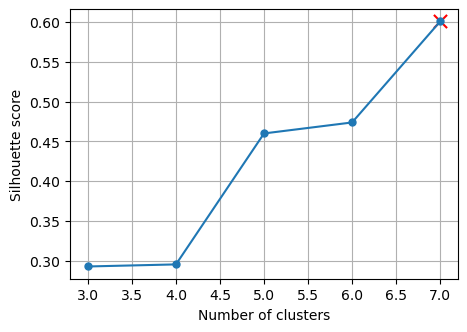

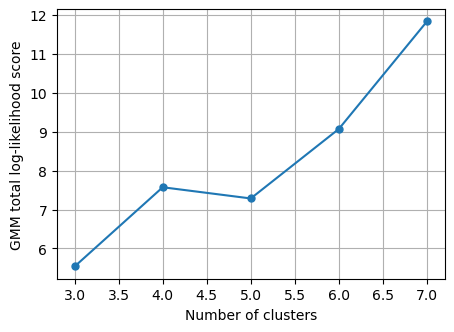

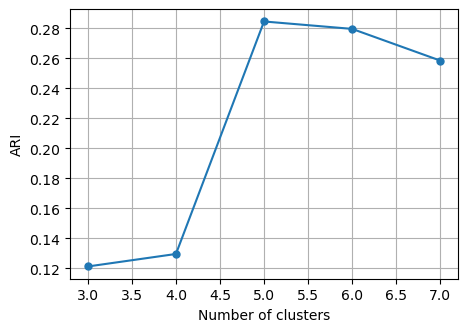

In [9]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, marker='o', markersize=5)
plt.scatter(best_n_gmm_kmeans, best_sh_gmm_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, log_l_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, ari_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()

### 2.2 Second case: init_params = random

In [10]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We compute the different scores for each iteration

#print(X_s)
#print(y)

# Arrays init
n_cluster_list_gmm_random = []
shs_list_gmm_random = []
ri_list_gmm_random = []
ari_list_gmm_random = []
log_l_list_gmm_random = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in initial_search_range)

n_cluster_list_gmm_random, shs_list_gmm_random, ri_list_gmm_random, ari_list_gmm_random, log_l_list_gmm_random = zip(
    *results_gmm_random)

# Find the best initial k
best_sh_gmm_random = np.max(shs_list_gmm_random)
best_n_gmm_random = n_cluster_list_gmm_random[np.argmax(shs_list_gmm_random)]

print("Best initial k: ", best_n_gmm_random, " with corresponding silhouette: ", best_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

# Refine search around the best k found
refined_n_cluster_list_gmm_random = []
refined_shs_list_gmm_random = []
refined_ri_list_gmm_random = []
refined_ari_list_gmm_random = []
refined_log_l_list_gmm_random = []

# Define the refined range
refined_range = range(max(3, best_n_gmm_random - 2), min(16, best_n_gmm_random + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in refined_range)

refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, refined_ri_list_gmm_random, refined_ari_list_gmm_random, refined_log_l_list_gmm_random = zip(
    *results_refined_gmm_random)

# Find the best refined k
best_refined_sh_gmm_random = np.max(refined_shs_list_gmm_random)
best_refined_n_gmm_random = refined_n_cluster_list_gmm_random[np.argmax(refined_shs_list_gmm_random)]
best_refined_gmm_random = np.array([best_refined_sh_gmm_random, best_refined_n_gmm_random])
print("Best refined k: ", best_refined_n_gmm_random, " with corresponding silhouette: ", best_refined_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

Best initial k:  3  with corresponding silhouette:  0.44878078445247965
Best refined k:  3  with corresponding silhouette:  0.44878078445247965
CPU times: user 72.5 ms, sys: 34 ms, total: 106 ms
Wall time: 1min 50s


#### Plots of Silhouette, Log-Likihood score and ARI


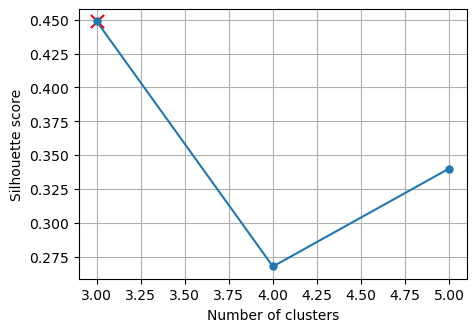

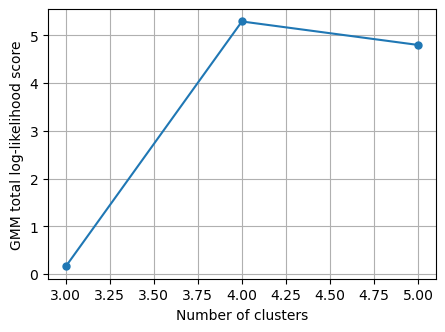

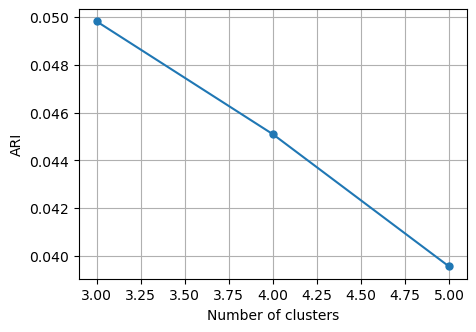

In [11]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, marker='o', markersize=5)
plt.scatter(best_refined_n_gmm_random, best_refined_sh_gmm_random, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_log_l_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_ari_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


In [12]:
%%time

# Plot ECDF per il numero di flussi per cluster
#plt.figure(figsize=(8, 5))
#sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
#plt.title('ECDF of Number of Flows per Cluster')
#plt.xlabel('Number of Flows')
#plt.ylabel('ECDF')
#plt.show()

CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 8.11 µs


## Conclusions

In this section, we decide which is the best method of clustering, and with which k.

In [13]:
# Comparing the silhouette scores
scores = {
    "KMeans (Refined)": best_refined_kmeans[0],
    "GMM (KMeans Init)": best_gmm_kmeans[0],
    "GMM (Random Init)": best_refined_gmm_random[0]
}

# Find the algorithm with the highest score
best_algorithm = max(scores, key=scores.get)
best_score = scores[best_algorithm]

# Output the best algorithm and its score
print(f"The best clustering algorithm is {best_algorithm} with a silhouette score of {best_score}.")

# If needed, output the corresponding number of clusters
if best_algorithm == "KMeans (Refined)":
    best_n = best_refined_kmeans[1]
elif best_algorithm == "GMM (KMeans Init)":
    best_n = best_gmm_kmeans[1]
else:
    best_n = best_refined_gmm_random[1]

print(f"The optimal number of clusters for {best_algorithm} is {best_n}.")

The best clustering algorithm is KMeans (Refined) with a silhouette score of 0.6593874731203916.
The optimal number of clusters for KMeans (Refined) is 11.0.


# Section 4
## Do clusters reflect the GT labels ?

We use the data and the results of the k-means attempt

In [31]:
%%time

# Let's use KMeans (we said that is the best)

best_refined_n_kmeans = 11
model = KMeans(n_clusters=best_refined_n_kmeans, random_state=42)
cluster_labels = model.fit_predict(X_s)

print(cluster_labels)

# Calculate clustering metrics
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")

[0 2 0 ... 2 2 2]
Silhouette Score: 0.6593874731203916
Adjusted Rand Index: 0.2427410657669912
CPU times: user 2min 24s, sys: 6min 46s, total: 9min 10s
Wall time: 1min 46s


In [14]:
# Find the index of best_refined_n in refined_n_cluster_list

best_refined_index = refined_n_cluster_list_kmeans.index(best_refined_n_kmeans)

# Use this index to get the corresponding cluster labels
best_refined_cl_labels = refined_cl_labels_list_kmeans[best_refined_index]

# best_refined_cl_labels now contains the cluster labels for the best refined clustering
ddos_tmp = ddos_data_original.copy()
ddos_tmp['assigned_cluster'] = best_refined_cl_labels

# Group by 'label' and count unique clusters for each label
unique_clusters_per_label = ddos_tmp.groupby('label')['assigned_cluster'].nunique()

# Create a new DataFrame from the result
label_cluster_count_df = unique_clusters_per_label.reset_index()
label_cluster_count_df.columns = ['Label', 'Unique_Clusters_Count']

# 'label_cluster_count_df' now contains each label with the count of unique clusters associated with it
print(label_cluster_count_df)

           Label  Unique_Clusters_Count
0         benign                      9
1       ddos_dns                      8
2      ddos_ldap                      5
3     ddos_mssql                      4
4   ddos_netbios                      3
5       ddos_ntp                      6
6      ddos_snmp                      1
7      ddos_ssdp                      5
8       ddos_syn                      4
9      ddos_tftp                      5
10      ddos_udp                      3
11  ddos_udp_lag                      1


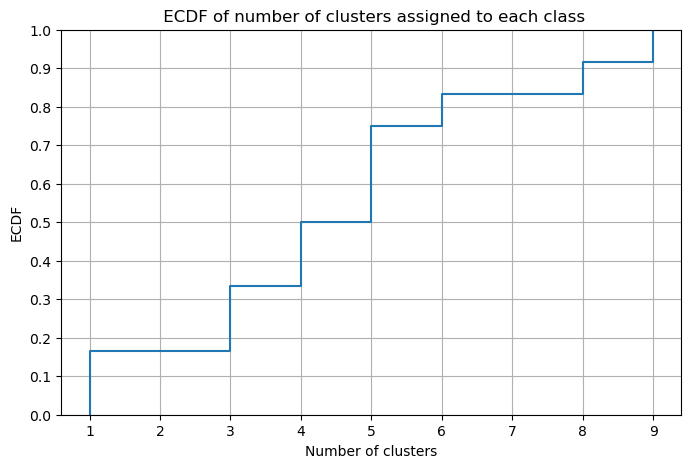

In [15]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

In [16]:
# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

Cluster 1 is not pure
Cluster 3 is not pure
Cluster 4 is not pure
Cluster 5 is not pure
Cluster 6 is pure
Cluster 8 is pure
Cluster 9 is pure


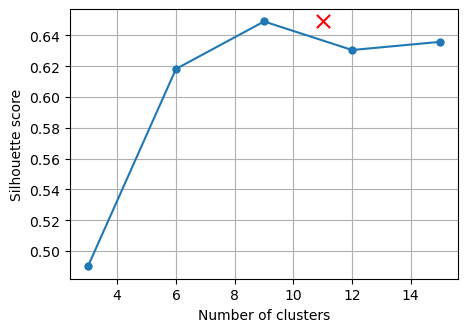

In [17]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_kmeans, shs_list_kmeans, marker='o', markersize=5)
plt.scatter(best_n, best_sh_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

## ECDF of number of clusters assigned to each class

In [19]:
%%time


# Analizza il numero di flussi per cluster
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 4.92 ms, sys: 1.14 ms, total: 6.06 ms
Wall time: 5.22 ms


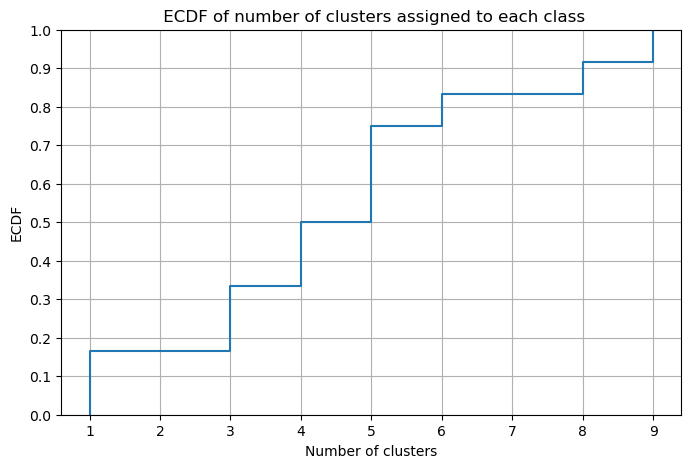

Cluster 1 is not pure
Cluster 3 is not pure
Cluster 4 is not pure
Cluster 5 is not pure
Cluster 6 is pure
Cluster 8 is pure
Cluster 9 is pure


In [20]:
# section 4
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

## What are the most important features in the obtained clusters?

Nota bene: non sono convinto che questa sezione sia corretta. Va rivista. 

Buongiorno professore,

La ringrazio per la risposta. Avrei ancora un dubbio su una questione: come faccio a capire quali sono le features più importanti se il database che ho dato in pasto a k-means è già stato trattato con la PCA e quindi ha molte meno colonne (9) rispetto alle features effettive (81)? Può darmi qualche guida in merito?

In attesa di una Sua cortese risposta, ringrazio anticipatamente e porgo cordiali saluti,

Giovanni de Maria

In [7]:
feature_importances = []

for cluster_num in range(best_refined_n_kmeans):
    # Creating binary labels for the current cluster
    class_labels = np.where(cluster_labels == cluster_num, 1, 0)

    # Splitting the data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_s, class_labels, test_size=0.3, random_state=42)

    # Training the logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    # Storing the coefficients (feature importance) for analysis
    feature_importances.append(classifier.coef_)

# Displaying the feature importances for each cluster


most_important_features = []
column_names = ddos_data.drop(columns=['label']).columns
for cluster_num, coefficients in enumerate(feature_importances):
    # Get the index of the most important feature (highest absolute coefficient)
    most_important_index = np.argmax(np.abs(coefficients))

    # Get the corresponding column name
    most_important_feature = column_names[most_important_index]

    # Store the cluster number, feature name, and its coefficient
    most_important_features.append((cluster_num, most_important_feature, coefficients[0][most_important_index]))

# Sorting the list by cluster number for better readability
most_important_features.sort(key=lambda x: x[0])

most_important_features

[(0, 'Flow Duration', 3.2144659831846867),
 (1, 'Protocol', -5.964615021509011),
 (2, 'Total Length of Fwd Packets', -3.7652424960356483),
 (3, 'Destination Port', 0.35952344740289305),
 (4, 'Source Port', 1.2786388083982638),
 (5, 'Total Length of Fwd Packets', -1.498123363949647),
 (6, 'Total Length of Bwd Packets', -3.213620911426158),
 (7, 'Fwd Packet Length Max', -0.35192978469019365),
 (8, 'Protocol', 1.2431962598831054),
 (9, 'Total Length of Bwd Packets', 1.5486291706239736),
 (10, 'Total Backward Packets', 0.10408208063491087)]

In [9]:
! git clone https://github.com/YousefGh/kmeans-feature-importance.git
! mv "./kmeans-feature-importance/kmeans_interp/" "."

fatal: destination path 'kmeans-feature-importance' already exists and is not an empty directory.
mv: cannot stat './kmeans-feature-importance/kmeans_interp/': No such file or directory


In [10]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp

In [14]:
kms = KMeansInterp(
    n_clusters=best_refined_n_kmeans, # Set the number of clusters to the number of actual unique categories
    random_state=1,
    ordered_feature_names=ddos_data.drop(columns=['label']).columns, # This method gets the feature names (Words) from
    feature_importance_method='wcss_min', # Or 'unsup2sup'
).fit(X)

In [20]:
X

array([[6.3400e+02, 6.0495e+04, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.3400e+02, 6.0495e+04, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.3400e+02, 4.6391e+04, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [4.6104e+04, 6.4704e+04, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.0686e+04, 1.0440e+04, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [4.5602e+04, 1.3870e+03, 1.7000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [21]:
ddos_data_interpr = ddos_data.copy()

ddos_data_interpr['Cluster'] = kms.labels_

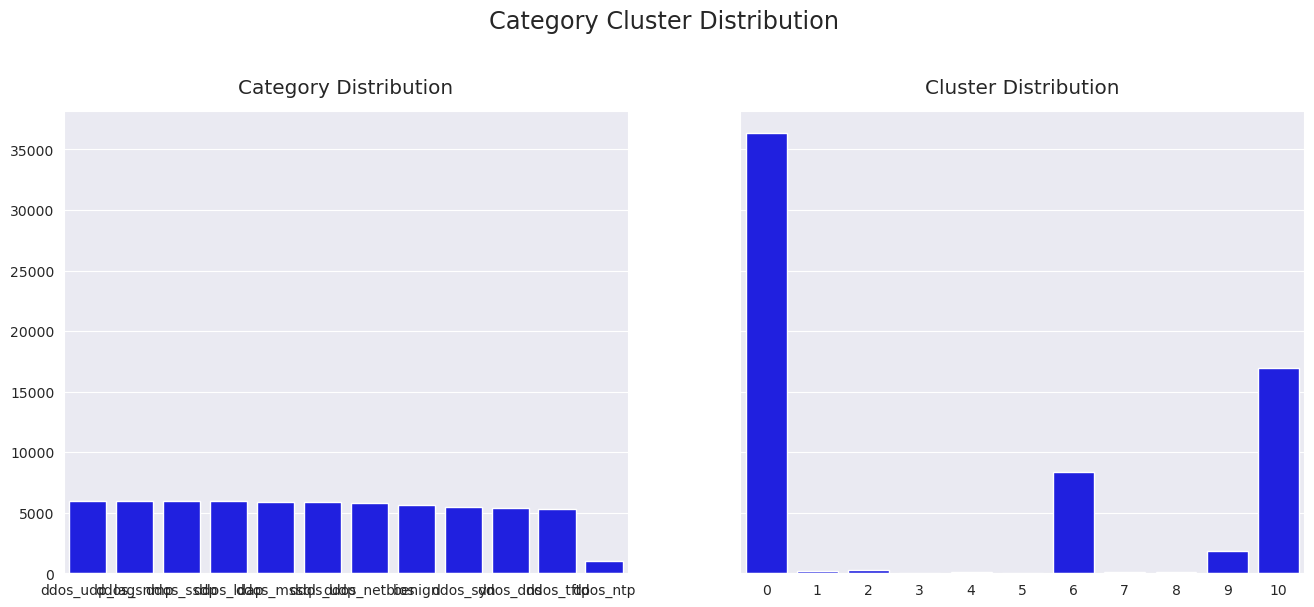

In [22]:
category_distrib = ddos_data_interpr['label'].value_counts()
cluster_distrib = ddos_data_interpr['Cluster'].value_counts()

# Plot both
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.suptitle('Category Cluster Distribution', fontsize='xx-large', y=1.05)
axs[0].set_title("Category Distribution", fontsize='x-large', y=1.02)
axs[1].set_title("Cluster Distribution", fontsize='x-large', y=1.02)

sns.barplot(x=category_distrib.index, y=category_distrib.values, ax=axs[0], color='b')
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, ax=axs[1], color='b');

In [23]:
ddos_data_interpr

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,label,Cluster
Flow ID,,,,,,,,,,,,,,,,,,,,,
172.16.0.5-192.168.50.1-634-60495-17,634,60495,17,28415,97,0,42680.0,0.0,440.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns,0
172.16.0.5-192.168.50.1-60495-634-17,634,60495,17,2,2,0,880.0,0.0,440.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ddos_dns,0
172.16.0.5-192.168.50.1-634-46391-17,634,46391,17,48549,200,0,88000.0,0.0,440.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns,0
172.16.0.5-192.168.50.1-634-11894-17,634,11894,17,48337,200,0,88000.0,0.0,440.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns,0
172.16.0.5-192.168.50.1-634-27878-17,634,27878,17,32026,200,0,88000.0,0.0,440.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172.16.0.5-192.168.50.1-38625-63051-17,38625,63051,17,1,2,0,750.0,0.0,375.0,375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag,10
172.16.0.5-192.168.50.1-58632-18963-17,58632,18963,17,212238,6,0,2088.0,0.0,393.0,321.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag,0
172.16.0.5-192.168.50.1-46104-64704-17,46104,64704,17,1,2,0,750.0,0.0,375.0,375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag,10


In [24]:
kms.feature_importances_[1][:10]

[('Fwd Header Length.1', 165000080427.63986),
 ('Fwd Header Length', 165000080427.63986),
 ('min_seg_size_forward', 1062718975.0000039),
 ('Flow Bytes/s', 2301612.274265051),
 ('Subflow Fwd Bytes', 72026.73170731707),
 ('Total Length of Fwd Packets', 72026.73170731707),
 ('Fwd IAT Total', 61376.7804878084),
 ('Flow Duration', 61376.780487799086),
 ('Destination Port', 34840.951219512186),
 ('Fwd IAT Max', 34289.31707317615)]

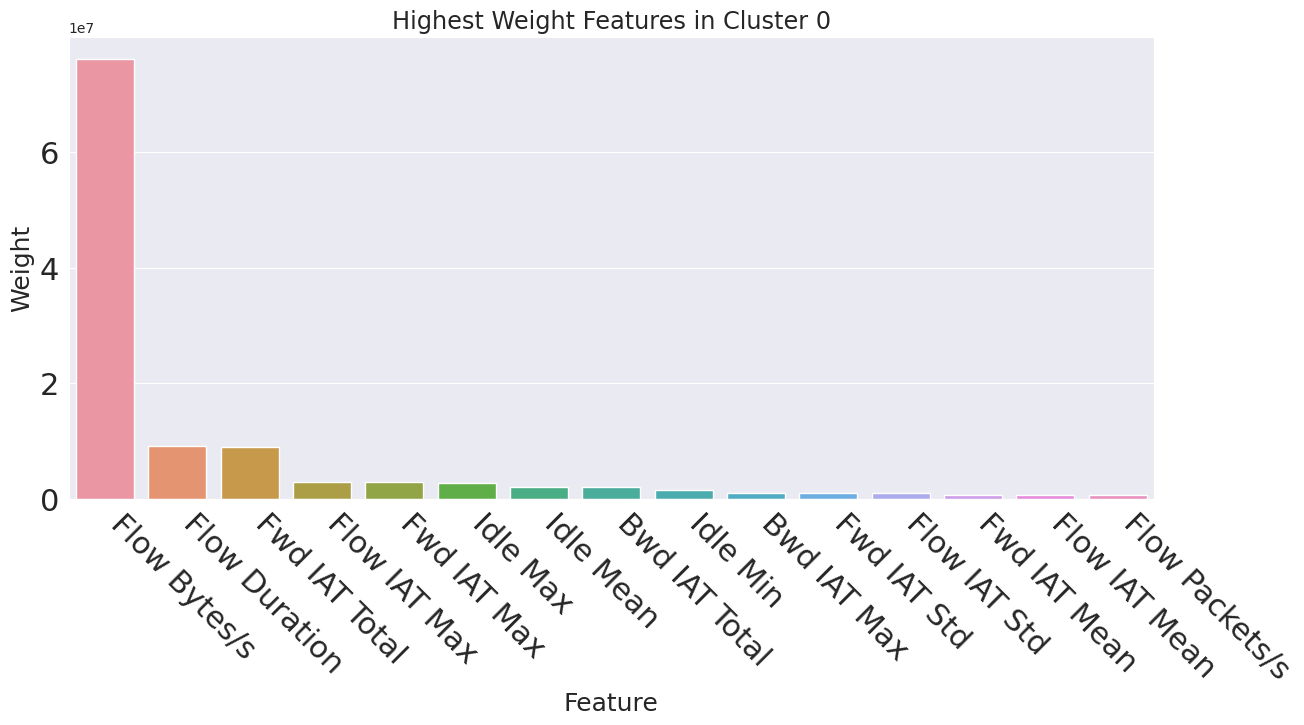

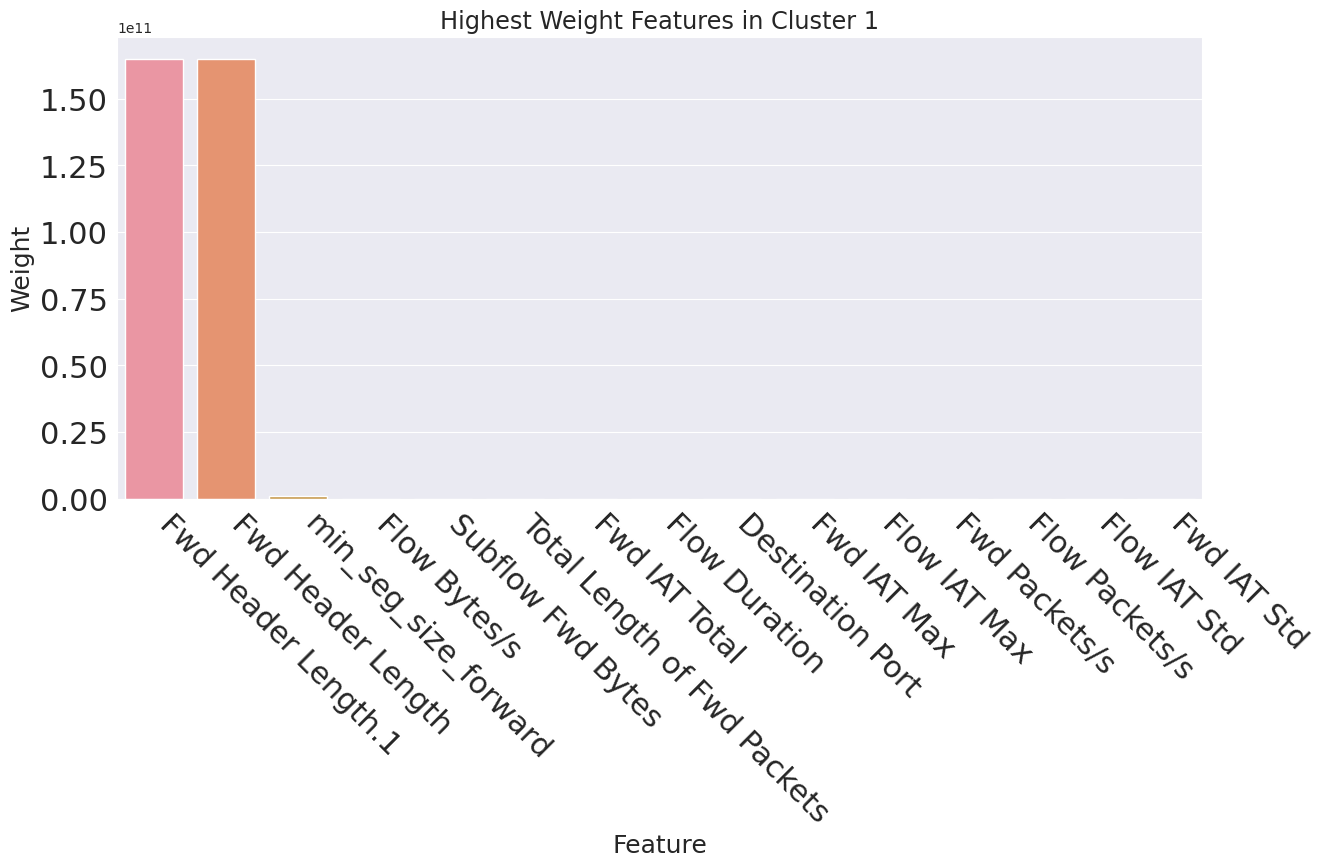

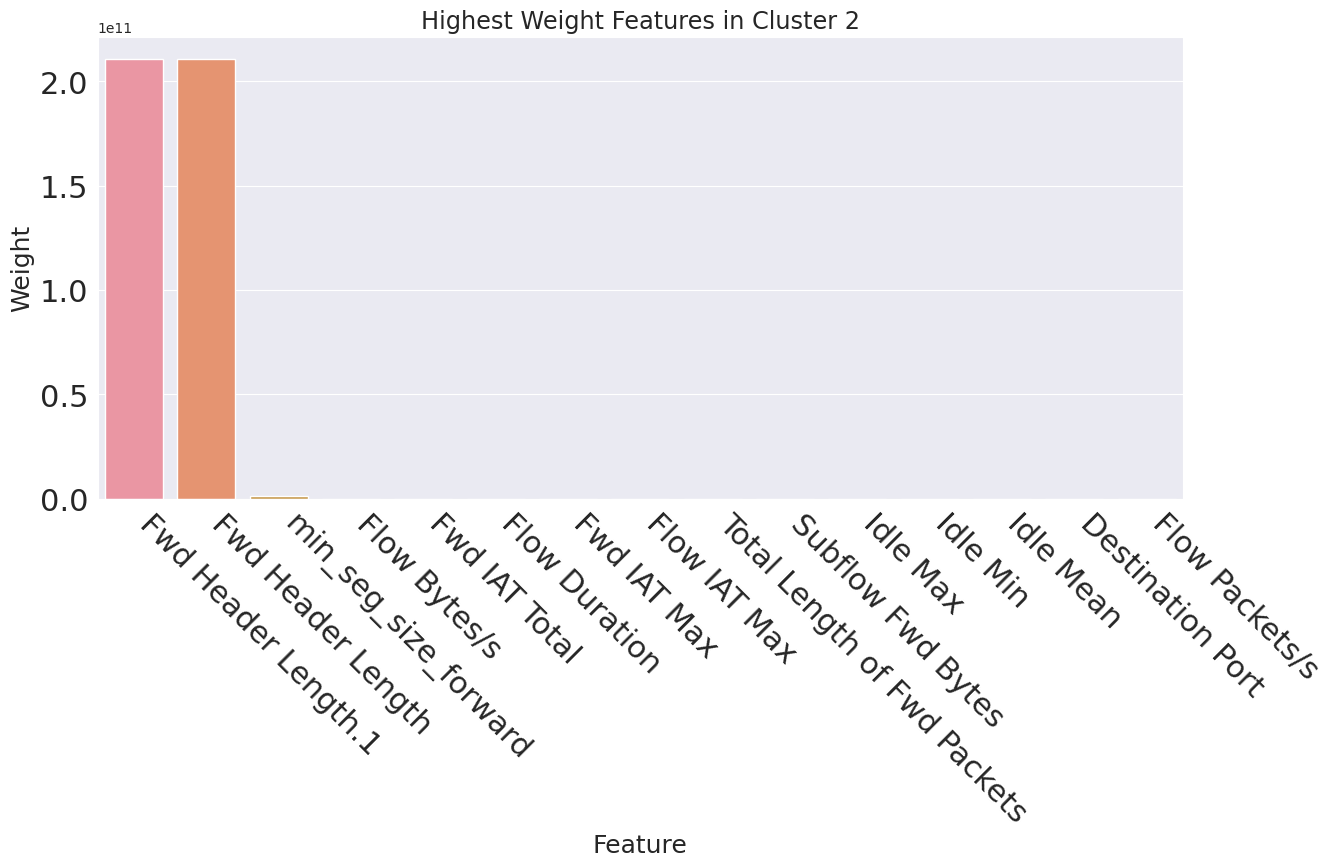

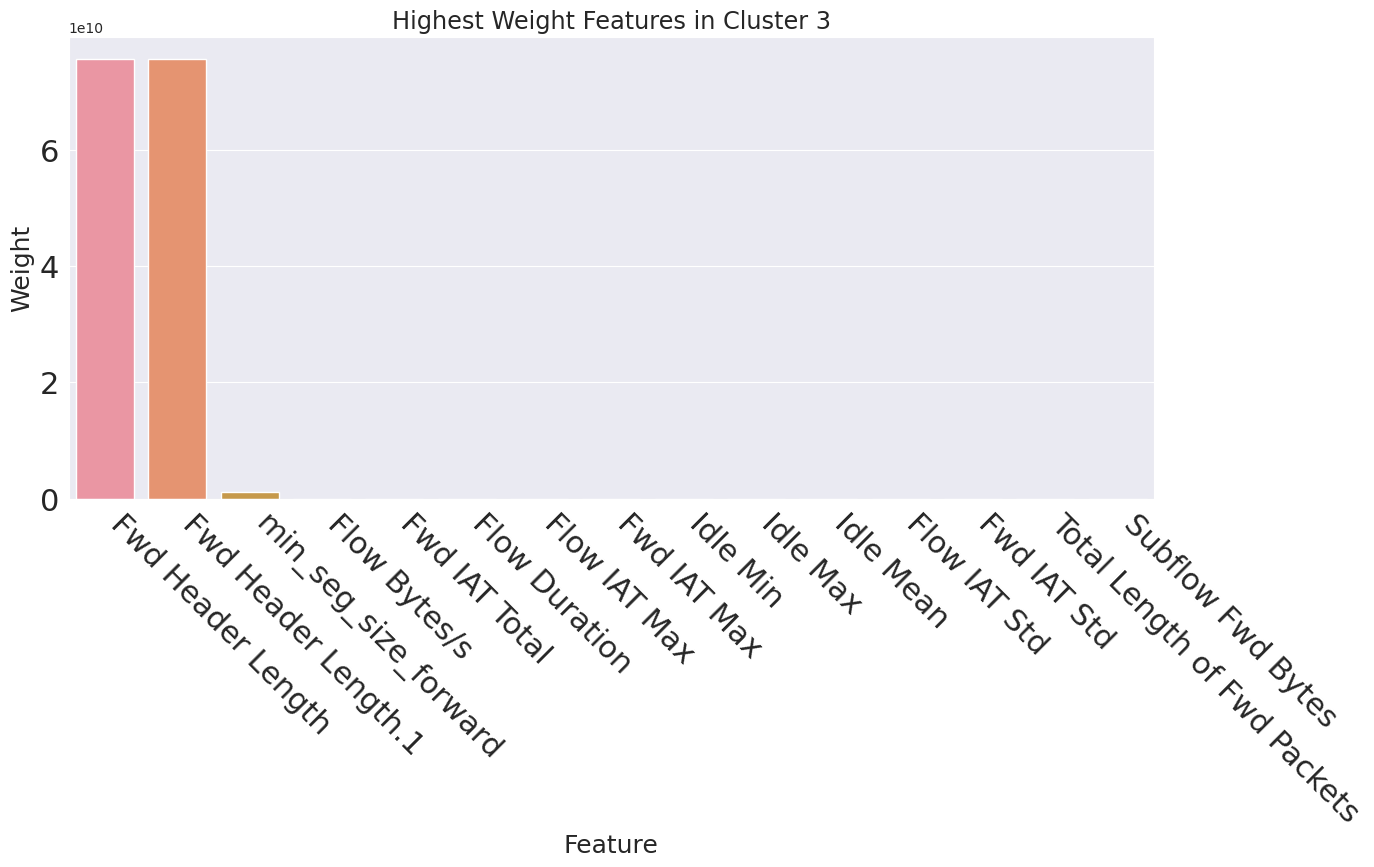

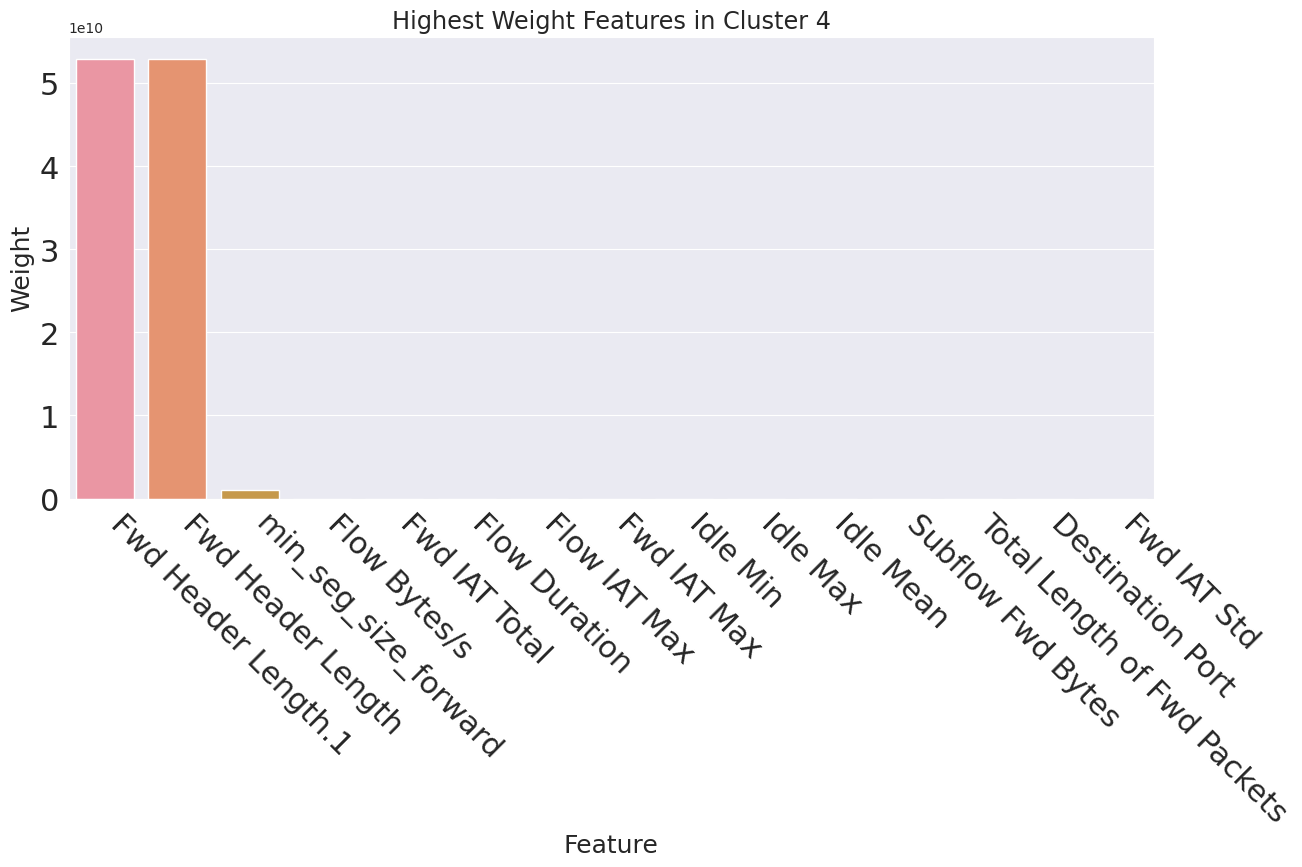

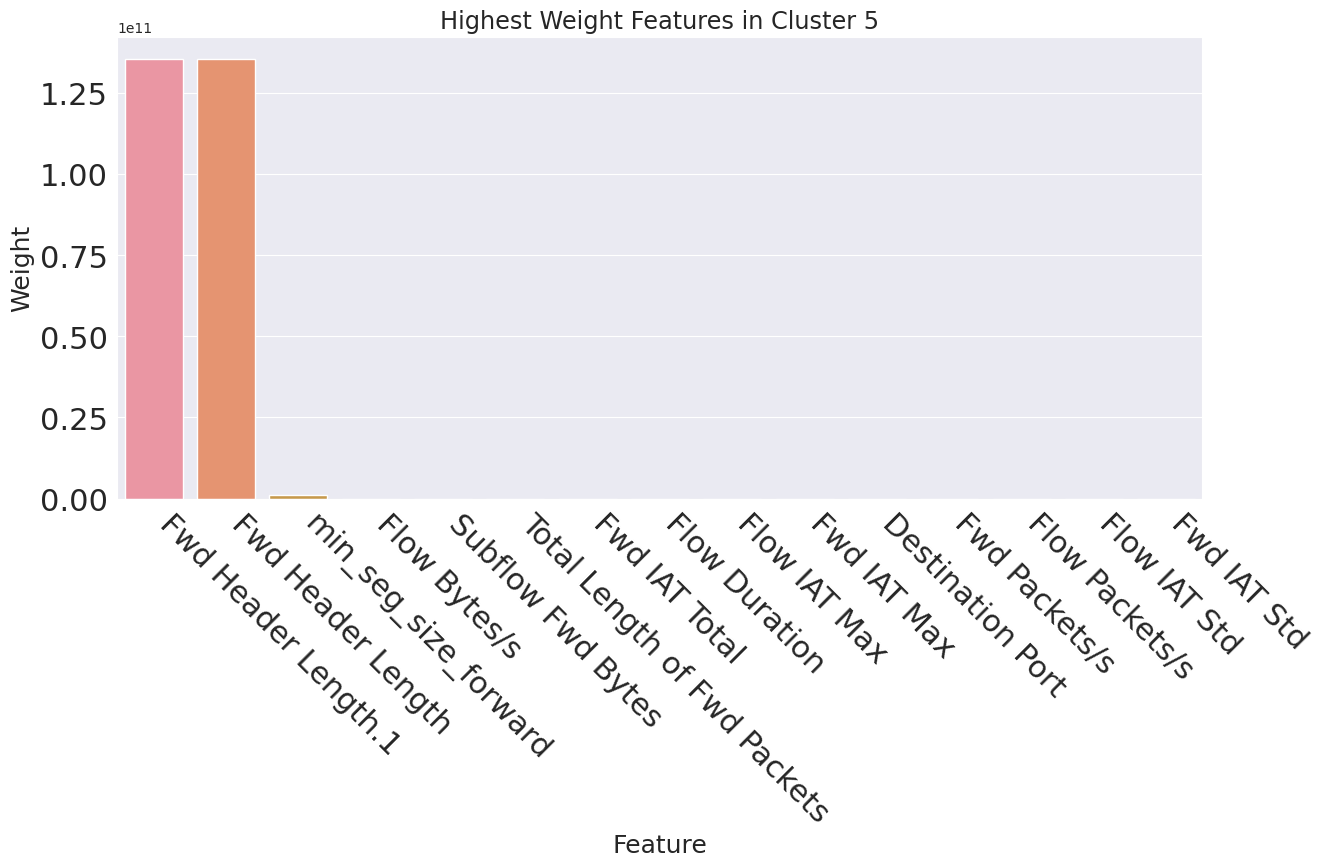

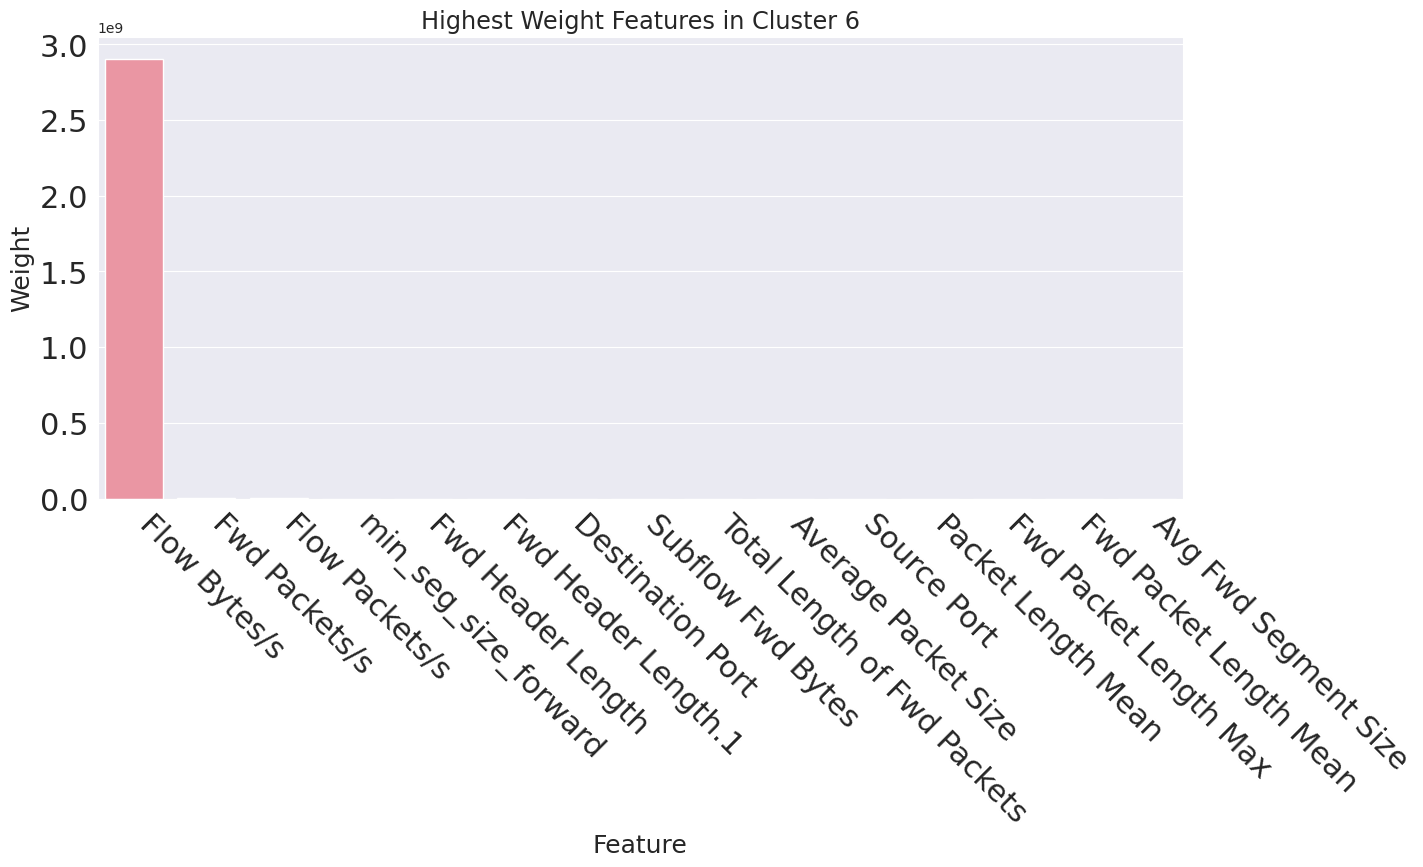

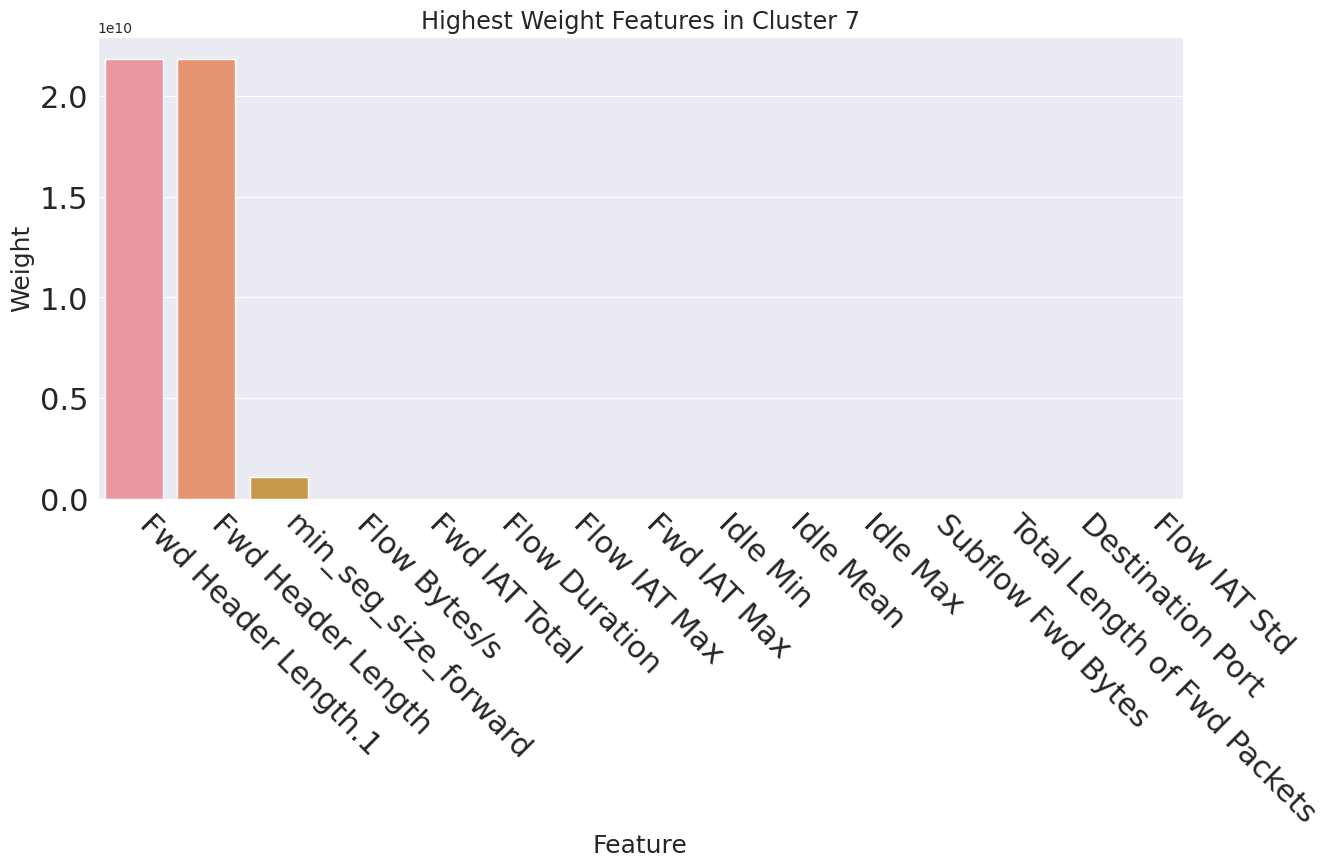

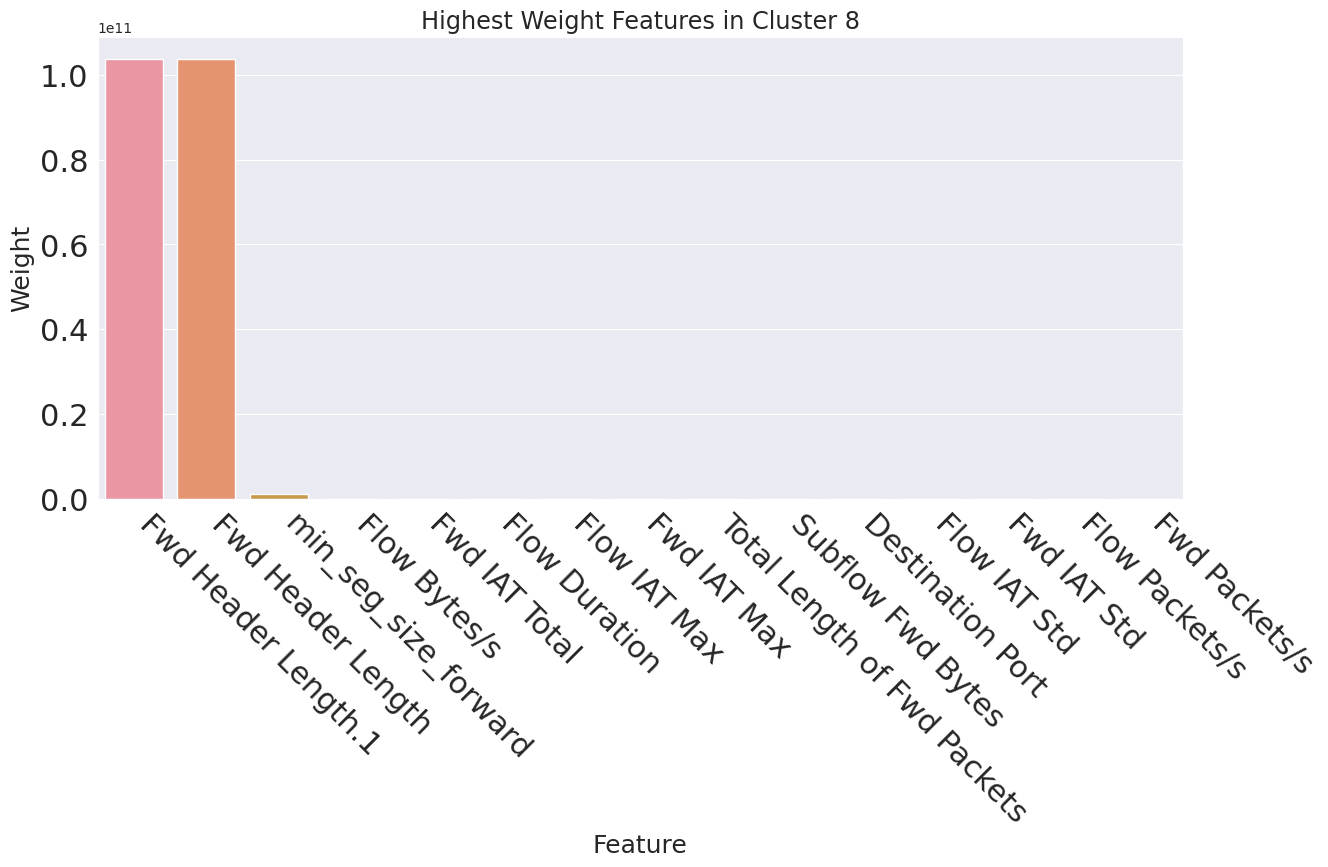

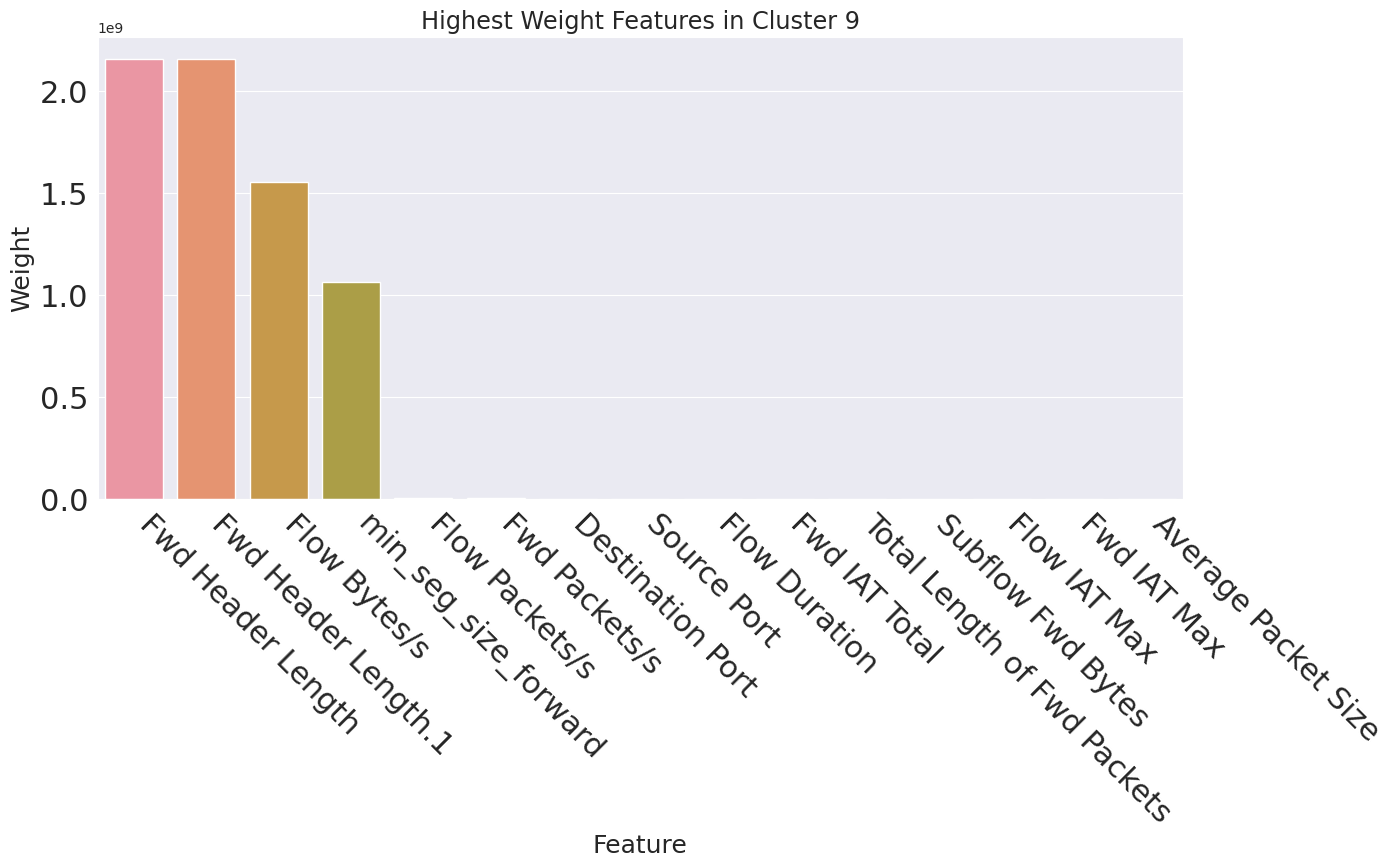

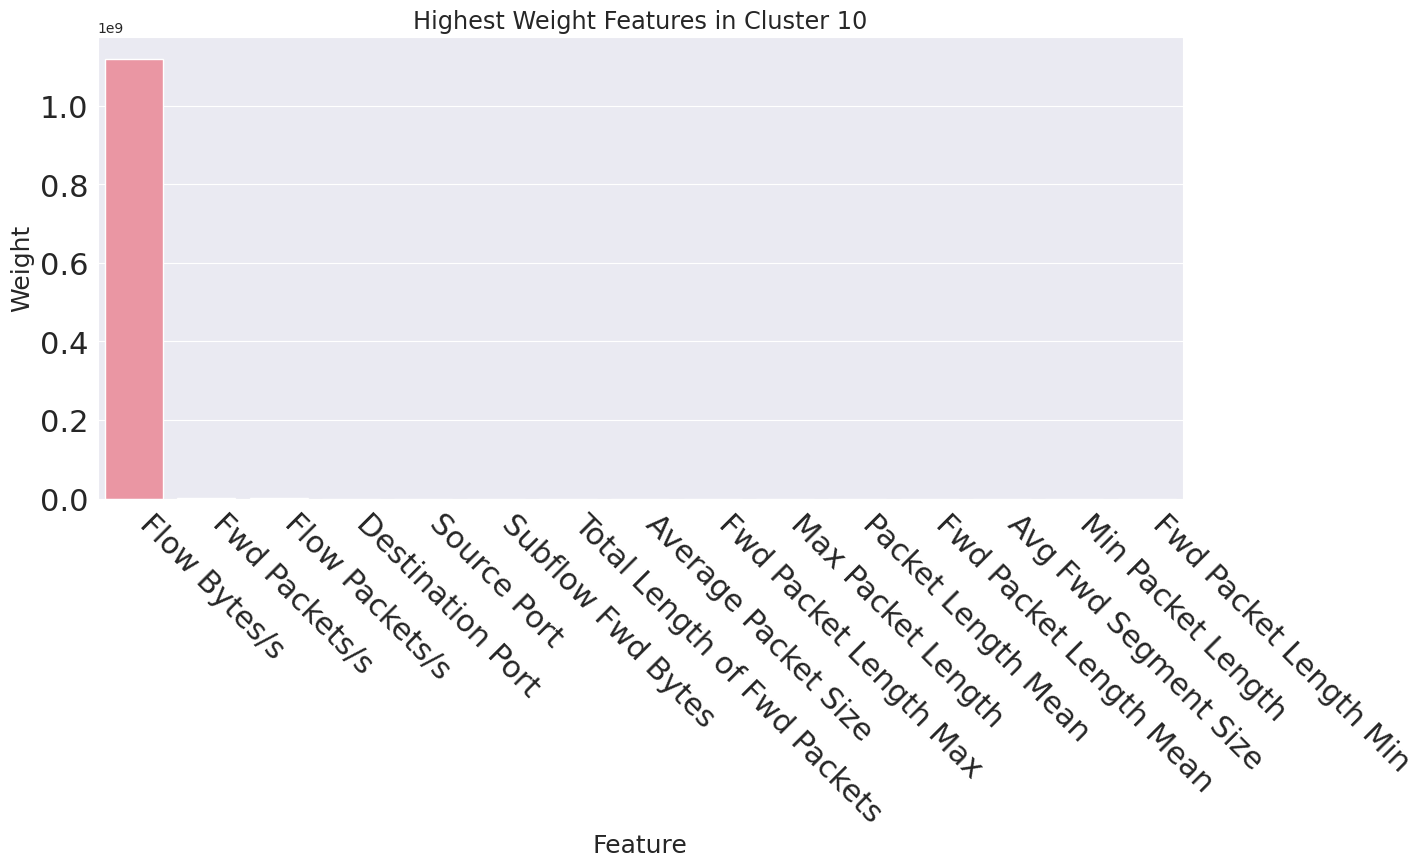

In [30]:
for cluster_label, feature_weights in kms.feature_importances_.items():
    df_feature_weight = pd.DataFrame(feature_weights[:15], columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left")
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Highest Weight Features in Cluster {cluster_label}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize=18)
    plt.ylabel('Weight', fontsize=18)

    plt.show()

    print('\n\n')